In [ ]:
!pip install streamlit
!pip install pyngrok
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


**Import các thư viện cần thiết**

In [ ]:
# IMPORT THƯ VIỆN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

**Loss Function**

In [ ]:
#src loss
class FocalLoss(nn.Module):
    """
    Focal Loss
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute p_t
        pt = torch.exp(-ce_loss)

        # Compute focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class WeightedFocalLoss(nn.Module):
    """
    Weighted Focal Loss

    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        # Áp dụng các weighted vào focal loss
        if self.alpha is not None:
            if self.alpha.type() != inputs.data.type():
                self.alpha = self.alpha.type_as(inputs.data)
            at = self.alpha.gather(0, targets.data.view(-1))
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


**Models VisoBert**

In [ ]:
# src models
class ViSoBERTEmotionClassifier(nn.Module):
    def __init__(self, model_name, num_classes=7, dropout_rate=0.3):
        super(ViSoBERTEmotionClassifier, self).__init__()

        # Load ViSoBERT model
        self.visobert = AutoModel.from_pretrained(model_name)

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(self.visobert.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.visobert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )


        pooled_output = outputs.pooler_output


        output = self.dropout(pooled_output)
        logits = self.classifier(output)

        return logits

In [ ]:
# src preprocessing
# 7 cảm xúc cơ bản
emotion_labels = {
    0: "Vui vẻ",
    1: "Buồn bã",
    2: "Tức giận",
    3: "Sợ hãi",
    4: "Ngạc nhiên",
    5: "Kinh tởm",
    6: "Khác"
}

# Mapping ngược từ tên cảm xúc về số
emotion_name_to_id = {
    "Enjoyment": 0,
    "Sadness": 1,
    "Anger": 2,
    "Fear": 3,
    "Surprise": 4,
    "Disgust": 5,
    "Other": 6,
}

def convert_label_to_int(label):
    """
    Chuyển đổi nhãn từ string sang int
    """
    if isinstance(label, (int, np.integer)):
        return int(label)
    elif isinstance(label, str):
        # Thử tìm trong mapping
        if label in emotion_name_to_id:
            return emotion_name_to_id[label]
        # Thử chuyển đổi trực tiếp từ string số
        try:
            return int(label)
        except ValueError:
            print(f"Warning: Không thể chuyển đổi nhãn '{label}', sử dụng nhãn 6 (Khác)")
            return 6
    else:
        print(f"Warning: Nhãn không hợp lệ '{label}', sử dụng nhãn 6 (Khác)")
        return 6

def calculate_class_weights(labels):
    """
    Tính toán trọng số cho các class để xử lý imbalanced data
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)

    # Tính trọng số nghịch đảo của tần suất
    weights = total_samples / (len(unique_labels) * counts)

    # Tạo tensor trọng số
    class_weights = torch.zeros(len(emotion_labels))
    for i, label in enumerate(unique_labels):
        class_weights[label] = weights[i]

    return class_weights

In [ ]:
import re, string


def normalText(sent):
    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon
        # VUI VẺ/THÍCH THÚ
        "😊": "Vui vẻ", "😁": "Vui vẻ", "😃": "Vui vẻ", "😄": "Vui vẻ",
        "😆": "Vui vẻ", "🤣": "Vui vẻ", "😹": "Vui vẻ", "😍": "Vui vẻ",
        "😘": "Vui vẻ", "😙": "Vui vẻ", "😚": "Vui vẻ", "😋": "Vui vẻ",
        "😛": "Vui vẻ", "😜": "Vui vẻ", "🤪": "Vui vẻ", "🤗": "Vui vẻ",
        "😎": "Vui vẻ", "🙂": "Vui vẻ", "💃": "Vui vẻ", "🕺": "Vui vẻ",
        "💖": "Vui vẻ", "💞": "Vui vẻ", "💗": "Vui vẻ", "💕": "Vui vẻ",
        "💓": "Vui vẻ", "❤️": "Vui vẻ", "❤": "Vui vẻ", "♥": "Vui vẻ",
        "💜": "Vui vẻ", "💙": "Vui vẻ", "💚": "Vui vẻ", "💛": "Vui vẻ",
        "💘": "Vui vẻ", "✨": "Vui vẻ", "🎉": "Vui vẻ", "🌟": "Vui vẻ",
        "🌸": "Vui vẻ", "🌺": "Vui vẻ", "🌼": "Vui vẻ", "😇": "Vui vẻ",

        # BUỒN BÃ
        "😢": "Buồn bã", "😭": "Buồn bã", "😞": "Buồn bã", "😔": "Buồn bã",
        "😟": "Buồn bã", "😿": "Buồn bã", "😩": "Buồn bã", "😫": "Buồn bã",
        "😓": "Buồn bã", "😥": "Buồn bã", "☹": "Buồn bã", "🙁": "Buồn bã",
        "😰": "Buồn bã", "😪": "Buồn bã", "😕": "Buồn bã",

        # TỨC GIẬN
        "😡": "Tức giận", "😠": "Tức giận", "🤬": "Tức giận", "👿": "Tức giận", "💢": "Tức giận",
        "😤": "Tức giận", "😾": "Tức giận", "🚫": "Tức giận",

        # NGẠC NHIÊN
        "😲": "Ngạc nhiên", "😯": "Ngạc nhiên", "😮": "Ngạc nhiên", "😳": "Ngạc nhiên",
        "😱": "Ngạc nhiên", "🤯": "Ngạc nhiên", "😵": "Ngạc nhiên",

        # SỢ HÃI
        "😨": "Sợ hãi", "😰": "Sợ hãi", "😖": "Sợ hãi", "😬": "Sợ hãi", "😧": "Sợ hãi",
        "😷": "Sợ hãi", "👻": "Sợ hãi", "😱": "Sợ hãi",

        # KINH TỞM
        "🤢": "Kinh tởm", "🤮": "Kinh tởm", "💩": "Kinh tởm", "😒": "Kinh tởm",
        "😑": "Kinh tởm", "😣": "Kinh tởm", "😠": "Kinh tởm", "👎": "Kinh tởm",

        # KHÁC
        "🤔": "Khác", "😐": "Khác", "🤨": "Khác", "😶": "Khác",
        "🙃": "Khác", "😏": "Khác", "🧐": "Khác", "😌": "Khác",
        "💀": "Khác", "🔥": "Khác", "?": "Khác", "…": "Khác",


        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}
    sent = sent.lower()
    for k, v in replace_list.items():
        sent = sent.replace(k, v)


    sent = str(sent).replace('_',' ').replace('/',' trên ')
    sent = re.sub('-{2,}','',sent)
    sent = re.sub('\\s+',' ', sent)
    patPrice = r'([0-9]+k?(\s?-\s?)[0-9]+\s?(k|K))|([0-9]+(.|,)?[0-9]+\s?(triệu|ngàn|trăm|k|K|))|([0-9]+(.[0-9]+)?Ä‘)|([0-9]+k)'
    patHagTag = r'#\s?[aăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ]+'
    patURL = r"(?:http://|www.)[^\"]+"
    sent = re.sub(patURL,'website',sent)
    sent = re.sub(patHagTag,' hagtag ',sent)
    sent = re.sub(patPrice, ' giá tiền ', sent)
    sent = re.sub(r'\.+','.',sent)
    sent = re.sub('(hagtag\\s+)+',' hagtag ',sent)
    sent = re.sub('\\s+',' ',sent)
    return sent

def normalize_elonge_word(sent):
    s_new = ''
    for word in sent.split(' '):
        word_new = ' '
        for char in word.strip():
            if char != word_new[-1]:
                word_new += char
        s_new += word_new.strip() + ' '
    return s_new.strip()

correct_mapping = {
    "ship": "vận chuyển",
    "shop": "cửa hàng",
    "m": "mình",
    "mik": "mình",
    "ko": "không",
    "k": " không ",
    "kh": "không",
    "khong": "không",
    "kg": "không",
    "khg": "không",
    "tl": "trả lời",
    "r": "rồi",
    "fb": "mạng xã hội",
    "face": "mạng xã hội",
    "thanks": "cảm ơn",
    "thank": "cảm ơn",
    "tks": "cảm ơn",
    "tk": "cảm ơn",
    "ok": "tốt",
    "dc": "được",
    "vs": "với",
    "đt": "điện thoại",
    "thjk": "thích",
    "qá": "quá",
    "trể": "trễ",
    "bgjo": "bao giờ",
    "bùn": "buồn"
}
def tokmap(tok):
    if tok.lower() in correct_mapping:
        return correct_mapping[tok.lower()]
    else:
        return tok


def clean_doc(doc, lower_case=True, word_segment=True, max_length=256):
    if not doc:
        return ""
    #  Chuẩn hóa văn bản
    doc = normalText(doc)

    # Chèn khoảng trắng quanh dấu "?" để tokenizer xử lý dễ hơn
    doc = re.sub(r"\?", r" ? ", doc)

    # Thay thế số bằng token "số"
    doc = re.sub(r"[0-9]+", " số ", doc)

    # Chuẩn hóa khoảng trắng
    doc = re.sub(r"\s+", " ", doc)

    # Chuẩn hóa các từ bị kéo dài (vd: "đẹppppp" → "đẹp")
    doc = normalize_elonge_word(doc)

    # Xử lý từ đặc biệt "giá tiền"
    if word_segment:
        doc = doc.replace("giá _ tiền", "giá_tiền").replace("giátiền", "giá_tiền")
    else:
        doc = doc.replace("giá _ tiền", "giá tiền").replace("giátiền", "giá tiền")

    # Chuẩn hóa khoảng trắng lần nữa
    doc = re.sub(r"\s+", " ", doc).strip()

    # Map từng token
    tokens = map(tokmap, doc.split())
    doc = " ".join(tokens)

    # Nếu chuỗi quá dài, giữ lại đầu + cuối (cắt giữa)
    array = doc.split()
    if len(array) > max_length:
        half = max_length // 2
        doc = " ".join(array[:half] + array[-half:])

    # 12. Thay thế một số mẫu đặc biệt
    doc = doc.replace(". . .", ".")

    return re.sub(r"\s+", " ", doc).strip()


In [ ]:
# src Data
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        #Tiền xử lý dữ liệu
        self.texts = [clean_doc(text) for text in texts]
        #Mapping Emotions sang số
        self.labels = [convert_label_to_int(label) for label in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize văn bản
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#Đọc dữ liệu
def load_data_from_files():
    """
    Hàm đọc dữ liệu từ 3 file train, test, val
    """
    try:
        # Đọc các file dữ liệu
        train_df = pd.read_excel('/content/train_nor_811.xlsx')
        test_df = pd.read_excel('/content/test_nor_811.xlsx')
        val_df = pd.read_excel('/content/valid_nor_811.xlsx')

        print(f"Train data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        print(f"Val data shape: {val_df.shape}")

        # Hiển thị cột để kiểm tra
        print(f"Train columns: {train_df.columns.tolist()}")

        # Hiển thị mẫu dữ liệu để kiểm tra
        print(f"Sample train data:")
        print(train_df.head())

        return train_df, test_df, val_df

    except FileNotFoundError as e:
        print(f"Lỗi: Không tìm thấy file dữ liệu - {e}")
        return None, None, None

In [ ]:
# src train
def train_model_with_focal_loss(model, train_loader, val_loader, epochs=3, lr=2e-5,
                               use_weighted_focal=True, alpha=1.0, gamma=2.0, class_weights=None,
                               save_best_model=True, model_save_path='/content/best_visobert_emotion_model.pth',
                               patience=3):
    """
    Hàm training model với Focal Loss và lưu model tốt nhất

    Args:
        model: Model để train
        train_loader: DataLoader cho training
        val_loader: DataLoader cho validation
        epochs: Số epoch
        lr: Learning rate
        use_weighted_focal: Có sử dụng weighted focal loss không
        alpha: Alpha parameter cho focal loss
        gamma: Gamma parameter cho focal loss
        class_weights: Trọng số cho các class
        save_best_model: Có lưu model tốt nhất không
        model_save_path: Đường dẫn lưu model tốt nhất
        patience: Số epoch chờ để early stopping
    """
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Chọn loss function
    if use_weighted_focal and class_weights is not None:
        criterion = WeightedFocalLoss(alpha=class_weights.to(device), gamma=gamma)
        print(f"Sử dụng Weighted Focal Loss với gamma={gamma}")
        print(f"Class weights: {class_weights}")
    else:
        criterion = FocalLoss(alpha=alpha, gamma=gamma)
        print(f"Sử dụng Focal Loss với alpha={alpha}, gamma={gamma}")

    # Khởi tạo các biến
    best_val_accuracy = 0.0
    best_epoch = 0
    epochs_without_improvement = 0

    train_losses = []
    val_accuracies = []
    best_model_state = None

    print(f"Sẽ lưu model tốt nhất tại: {model_save_path}")

    for epoch in range(epochs):
        print(f'\n========== EPOCH {epoch + 1}/{epochs} ==========')

        # Training phase
        model.train()
        total_train_loss = 0

        progress_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({'focal_loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f'Training Focal Loss: {avg_train_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')

        # Kiểm tra và lưu model tốt nhất
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            # Lưu state của model tốt nhất
            if save_best_model:
                best_model_state = model.state_dict().copy()
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_accuracy': best_val_accuracy,
                    'train_loss': avg_train_loss,
                    'hyperparameters': {
                        'lr': lr,
                        'alpha': alpha,
                        'gamma': gamma,
                        'use_weighted_focal': use_weighted_focal
                    }
                }, model_save_path)

            print(f'NEW BEST MODEL! Val Accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})')
        else:
            epochs_without_improvement += 1
            print(f' Current best: {best_val_accuracy:.4f} (Epoch {best_epoch})')
            print(f'Epochs without improvement: {epochs_without_improvement}/{patience}')

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'\n Early stopping triggered after {patience} epochs without improvement')
            print(f'Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}')
            break

    # Load lại model tốt nhất sau khi training xong
    if save_best_model and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'\n Loaded best model from epoch {best_epoch} (Val Accuracy: {best_val_accuracy:.4f})')

    return train_losses, val_accuracies, best_val_accuracy, best_epoch


In [ ]:
#src evaluate
def evaluate_model(model, data_loader):
    """
    Hàm đánh giá model
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

def detailed_evaluation(model, data_loader, dataset_name="Test"):
    """
    Đánh giá chi tiết
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f'Evaluating {dataset_name}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Tính accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\n{dataset_name} Accuracy: {accuracy:.4f}")

    # Classification Report
    print(f"\n{dataset_name} Classification Report:")
    target_names = [emotion_labels[i] for i in range(len(emotion_labels))]
    print(classification_report(true_labels, predictions, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return accuracy, predictions, true_labels


In [ ]:
# src load lại model tốt nhất
def load_best_model(model, model_path='/content/best_visobert_emotion_model.pth'):
    """
    Load model tốt nhất đã lưu
    """
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        return checkpoint

    except FileNotFoundError:
        print(f" Không tìm thấy file model: {model_path}")
        return None
    except Exception as e:
        print(f"Lỗi khi load model: {e}")
        return None

In [ ]:
# src predict
def predict_emotion(model, tokenizer, text, max_length=256):
    """
    Dự đoán cảm xúc cho một câu văn bản
    """
    model.eval()

    text = clean_doc(text)

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return {
        'emotion': emotion_labels[predicted_class],
        'confidence': confidence,
        'probabilities': {emotion_labels[i]: prob.item()
                         for i, prob in enumerate(probabilities[0])}
    }

In [ ]:
# src main
def main():
    print("========== BẮT ĐẦU TRAINING ==========")

    # 1. Load dữ liệu
    print("\n1. Loading data...")
    train_df, test_df, val_df = load_data_from_files()


    # Xử lý tên cột
    text_column = 'Sentence'
    label_column = 'Emotion'

    if text_column != 'Sentence' or label_column != 'Emotion':
        print("Lỗi: Không tìm thấy tên cột")
        print(f"Các cột có sẵn: {train_df.columns.tolist()}")
        return

    print(f"Sử dụng cột text: '{text_column}', cột label: '{label_column}'")

    # Kiểm tra và hiển thị phân bố nhãn
    print(f"\nPhân bố nhãn trong train set:")
    label_counts = train_df[label_column].value_counts()
    print(label_counts)

    # Tính toán class weights
    train_labels = [convert_label_to_int(label) for label in train_df[label_column].tolist()]
    class_weights = calculate_class_weights(train_labels)
    print(f"\nClass weights: {class_weights}")

    # 2. Load tokenizer và model
    print("\n2. Loading ViSoBERT model:")
    model_name = "uitnlp/visobert"  # ViSoBERT model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # 3. Tạo DataLoader
    print("\n3. Creating DataLoader:")
    train_dataset = EmotionDataset(
        train_df[text_column].tolist(),
        train_df[label_column].tolist(),
        tokenizer
    )

    val_dataset = EmotionDataset(
        val_df[text_column].tolist(),
        val_df[label_column].tolist(),
        tokenizer
    )

    test_dataset = EmotionDataset(
        test_df[text_column].tolist(),
        test_df[label_column].tolist(),
        tokenizer
    )


    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # 4. Khởi tạo model
    print("\n4. Initializing model...")
    model = ViSoBERTEmotionClassifier(model_name, num_classes=7)
    model.to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # 5. Training với Focal Loss và Best Model Saving
    print("\n5. Starting training with Focal Loss and Best Model Saving...")
    train_losses, val_accuracies, best_val_acc, best_epoch = train_model_with_focal_loss(
        model, train_loader, val_loader,
        epochs=10,
        lr=2e-5,
        use_weighted_focal=True,
        alpha=1.0,
        gamma=2.0,
        class_weights=class_weights,
        save_best_model=True,
        model_save_path='/content/best_visobert_emotion_model.pth',
        patience=3
    )

    # 6. Vẽ biểu đồ training
    print("\n6. Plotting training progress...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, 'b-', label='Training Focal Loss')
    ax1.set_title('Training Focal Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy', marker='o')
    ax2.axhline(y=best_val_acc, color='g', linestyle='--',
                label=f'Best Acc: {best_val_acc:.4f} (Epoch {best_epoch})')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # 7. Đánh giá trên test set với model tốt nhất
    print("\n7. Final evaluation on test set with best model...")
    test_accuracy, test_preds, test_labels = detailed_evaluation(
        model, test_loader, "Test"
    )

    # 8. Thông tin tổng kết
    print(f"\n========== KẾT QUẢ CUỐI CÙNG ==========")
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Best model saved at: /content/best_visobert_emotion_model.pth")

    # 9. Test dự đoán với một vài câu mẫu
    print("\n8. Testing predictions with best model...")
    test_sentences = [
        "Hôm nay tôi rất vui vì được gặp bạn bè",
        "Tôi buồn vì phải xa nhà lâu rồi",
        "Tôi giận lắm vì bị ai đó lừa dối",
        "Tôi sợ đi một mình vào ban đêm",
        "Ồ, không ngờ bạn lại ở đây!"
    ]

    for sentence in test_sentences:
        result = predict_emotion(model, tokenizer, sentence)
        print(f"\nCâu: '{sentence}'")
        print(f"Cảm xúc: {result['emotion']} (độ tin cậy: {result['confidence']:.4f})")

    print("\n========== HOÀN THÀNH! ==========")

    return model, tokenizer, best_val_acc, best_epoch


Using device: cpu


========== BẮT ĐẦU TRAINING VISOBERT EMOTION RECOGNITION VỚI FOCAL LOSS VÀ BEST MODEL SAVING ==========

1. Loading data...
Train data shape: (5548, 3)
Test data shape: (693, 3)
Val data shape: (686, 3)
Train columns: ['Unnamed: 0', 'Emotion', 'Sentence']
Sample train data:
   Unnamed: 0    Emotion                                           Sentence
0         188      Other              cho mình xin bài nhạc tên là gì với ạ
1         166    Disgust  cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2        1345    Disgust  lo học đi . yêu đương lol gì hay lại thích học...
3         316  Enjoyment    uớc gì sau này về già vẫn có thể như cụ này :))
4        1225  Enjoyment  mỗi lần có video của con là cứ coi đi coi lại ...
Sử dụng cột text: 'Sentence', cột label: 'Emotion'

Phân bố nhãn trong train set:
Emotion
Enjoyment    1558
Disgust      1071
Other        1021
Sadness       947
Anger         391
Fear          318
Surprise      242
Name: count, dtype: int64

Class weights: tensor([0.5

Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 97,963,271

5. Starting training with Focal Loss and Best Model Saving...
Sử dụng Weighted Focal Loss với gamma=2.0
Class weights: tensor([0.5087, 0.8369, 2.0270, 2.4924, 3.2751, 0.7400, 0.7763])
Sẽ lưu model tốt nhất tại: /content/best_visobert_emotion_model.pth

========== EPOCH 1/10 ==========


Training Epoch 1: 100%|██████████| 347/347 [03:50<00:00,  1.51it/s, focal_loss=0.543]


Training Focal Loss: 0.8841
Validation Accuracy: 0.6224
✅ NEW BEST MODEL! Val Accuracy: 0.6224 (Epoch 1)

========== EPOCH 2/10 ==========


Training Epoch 2: 100%|██████████| 347/347 [03:49<00:00,  1.51it/s, focal_loss=0.195]


Training Focal Loss: 0.3884
Validation Accuracy: 0.6429
✅ NEW BEST MODEL! Val Accuracy: 0.6429 (Epoch 2)

========== EPOCH 3/10 ==========


Training Epoch 3: 100%|██████████| 347/347 [03:49<00:00,  1.51it/s, focal_loss=0.197]


Training Focal Loss: 0.2003
Validation Accuracy: 0.6706
✅ NEW BEST MODEL! Val Accuracy: 0.6706 (Epoch 3)

========== EPOCH 4/10 ==========


Training Epoch 4: 100%|██████████| 347/347 [03:49<00:00,  1.51it/s, focal_loss=0.209]


Training Focal Loss: 0.0835
Validation Accuracy: 0.6603
📊 Current best: 0.6706 (Epoch 3)
⏳ Epochs without improvement: 1/3

========== EPOCH 5/10 ==========


Training Epoch 5: 100%|██████████| 347/347 [03:48<00:00,  1.52it/s, focal_loss=0.0865]


Training Focal Loss: 0.0399
Validation Accuracy: 0.6691
📊 Current best: 0.6706 (Epoch 3)
⏳ Epochs without improvement: 2/3

========== EPOCH 6/10 ==========


Training Epoch 6: 100%|██████████| 347/347 [03:48<00:00,  1.52it/s, focal_loss=0.00073]


Training Focal Loss: 0.0145
Validation Accuracy: 0.6720
✅ NEW BEST MODEL! Val Accuracy: 0.6720 (Epoch 6)

========== EPOCH 7/10 ==========


Training Epoch 7: 100%|██████████| 347/347 [03:49<00:00,  1.51it/s, focal_loss=0.00028]


Training Focal Loss: 0.0047
Validation Accuracy: 0.6603
📊 Current best: 0.6720 (Epoch 6)
⏳ Epochs without improvement: 1/3

========== EPOCH 8/10 ==========


Training Epoch 8: 100%|██████████| 347/347 [03:48<00:00,  1.52it/s, focal_loss=0.000269]


Training Focal Loss: 0.0018
Validation Accuracy: 0.6603
📊 Current best: 0.6720 (Epoch 6)
⏳ Epochs without improvement: 2/3

========== EPOCH 9/10 ==========


Training Epoch 9: 100%|██████████| 347/347 [03:48<00:00,  1.52it/s, focal_loss=0.002]


Training Focal Loss: 0.0007
Validation Accuracy: 0.6706
📊 Current best: 0.6720 (Epoch 6)
⏳ Epochs without improvement: 3/3

🛑 Early stopping triggered after 3 epochs without improvement
🏆 Best validation accuracy: 0.6720 at epoch 6

🔄 Loaded best model from epoch 6 (Val Accuracy: 0.6720)

6. Plotting training progress...


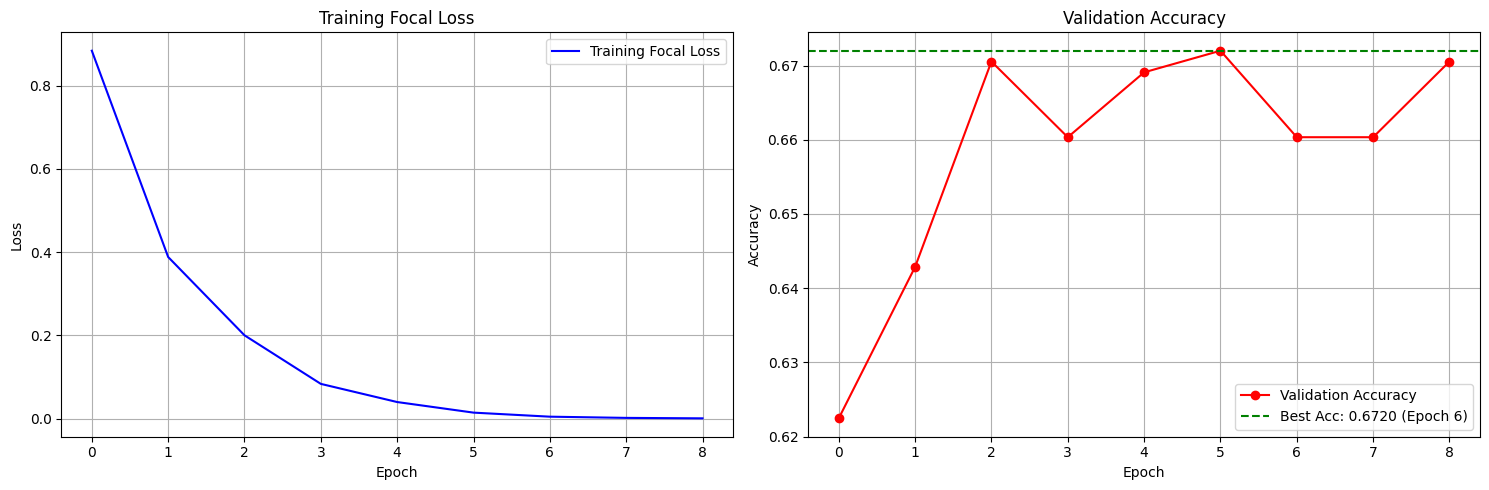


7. Final evaluation on test set with best model...


Evaluating Test: 100%|██████████| 44/44 [00:08<00:00,  5.19it/s]



Test Accuracy: 0.6869

Test Classification Report:
              precision    recall  f1-score   support

      Vui vẻ       0.78      0.75      0.77       193
     Buồn bã       0.75      0.71      0.73       116
    Tức giận       0.68      0.53      0.59        40
      Sợ hãi       0.73      0.72      0.73        46
  Ngạc nhiên       0.63      0.46      0.53        37
    Kinh tởm       0.63      0.75      0.68       132
        Khác       0.58      0.61      0.60       129

    accuracy                           0.69       693
   macro avg       0.68      0.65      0.66       693
weighted avg       0.69      0.69      0.69       693



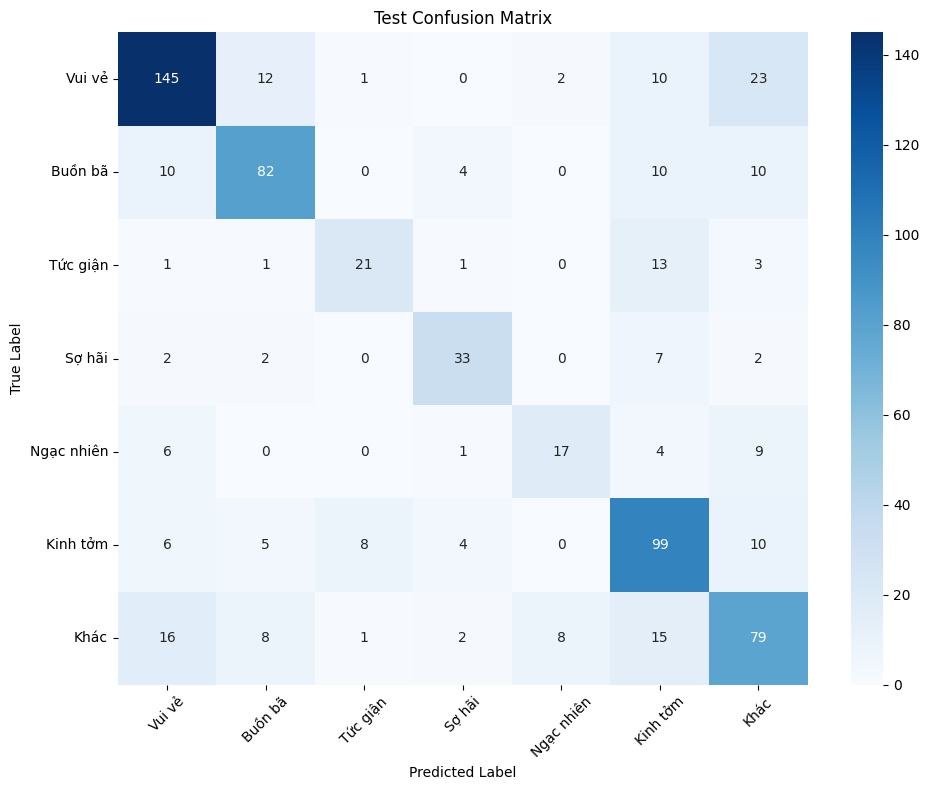


========== KẾT QUẢ CUỐI CÙNG ==========
🏆 Best Validation Accuracy: 0.6720 (Epoch 6)
📊 Final Test Accuracy: 0.6869
💾 Best model saved at: /content/best_visobert_emotion_model.pth

8. Testing predictions with best model...

Câu: 'Hôm nay tôi rất vui vì được gặp bạn bè'
Cảm xúc: Vui vẻ (độ tin cậy: 0.9341)

Câu: 'Tôi buồn vì phải xa nhà lâu rồi'
Cảm xúc: Buồn bã (độ tin cậy: 0.9665)

Câu: 'Tôi giận lắm vì bị ai đó lừa dối'
Cảm xúc: Buồn bã (độ tin cậy: 0.9332)

Câu: 'Tôi sợ đi một mình vào ban đêm'
Cảm xúc: Sợ hãi (độ tin cậy: 0.9731)

Câu: 'Ồ, không ngờ bạn lại ở đây!'
Cảm xúc: Ngạc nhiên (độ tin cậy: 0.9637)

========== HOÀN THÀNH! ==========


ValueError: too many values to unpack (expected 2)

In [ ]:
# ==================== CHẠY CHƯƠNG TRÌNH ====================
if __name__ == "__main__":
    # Chạy chương trình chính
    model, tokenizer, best_val_acc, best_epoch  = main()

In [ ]:
#lưu lại model best
torch.save(model.state_dict(), '/content/best_visobert_emotion_model.pth')
#tải về
from google.colab import files
files.download('/content/best_visobert_emotion_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2yH7CFO2f9tq8r2eRtr6Of3BhrK_4XtenJJYyFpQ19UcoSXHP")


In [ ]:
!python /content/preprocessing.py

In [ ]:
!python /content/VisoBert-app.py

In [ ]:
# ==================== SETUP NGROK VÀ CHẠY STREAMLIT ====================
import subprocess
import threading
from pyngrok import ngrok
import time

# Tạo ngrok tunnel
print("🚀 Đang tạo ngrok tunnel...")
public_url = ngrok.connect(8501)


# Chạy streamlit trong background
def run_streamlit():
    subprocess.run(["streamlit", "run", "VisoBert-app.py", "--server.port", "8501", "--server.headless", "true"])

# Start streamlit in a separate thread
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True
streamlit_thread.start()

print("⏳ Đang khởi động Streamlit app...")
print(f"🌐 Truy cập ứng dụng tại: {public_url}")


# Keep the notebook running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("🛑 Dừng ứng dụng...")
    ngrok.disconnect(public_url)
    ngrok.kill()

🚀 Đang tạo ngrok tunnel...
⏳ Đang khởi động Streamlit app...
🌐 Truy cập ứng dụng tại: NgrokTunnel: "https://e25e-35-225-161-236.ngrok-free.app" -> "http://localhost:8501"
